In [2]:
import math

def R_from_axis_angle(axis, angle):
    """ Find the rotation matrix R(K, theta) 
        @param axis (K): axis of rotation and 
        @param theta: rotation angle in degrees
        @return R: rotation matrix (3x3 numpy array)
    """
    sina = math.sin(angle * np.pi/180) # convert to radians
    cosa = math.cos(angle * np.pi/180) # convert to radians
    axis = unit_vector(axis[:3])
    kx = axis[0]; ky = axis[1]; kz = axis[2]
    # rotation matrix around unit vector
    
    R = np.array([
                [(kx**2)*(1-cosa) + cosa, kx*ky*(1-cosa)-kz*sina, kx*kz*(1-cosa)+ky*sina],
                [kx*ky*(1-cosa)+kz*sina, (ky**2)*(1-cosa) + cosa, ky*kz*(1-cosa)-kx*sina],
                [kx*kz*(1-cosa)-ky*sina, ky*kz*(1-cosa)+kx*sina, (kz**2)*(1-cosa) + cosa]
                ])
    
    return R

def rotate_water(x, axis, angle):
    rotation_matrix = R_from_axis_angle(axis, angle)
    new_x = np.array([0.0, 0.0, 0.0,0.0, 0.0, 0.0,0.0, 0.0, 0.0], requires_grad=True)
    
    # Rotate each vertex
    point1 = x[0:3]
    point1_rot = np.dot(rotation_matrix, point1) # Ordering matters. First rotate, then translate.
    point1_rot += transl_vec
    new_x[0:3] = point1_rot
    
    point2 = x[3:6]
    point2_rot = np.dot(rotation_matrix, point2)
    point2_rot += transl_vec
    new_x[3:6] = point2_rot
    
    point3 = x[6:9]
    point3_rot = np.dot(rotation_matrix, point3)
    point3_rot += transl_vec
    new_x[6:9] = point3_rot
    
    return new_x

In [3]:
# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

def build_xyz(r, angle): # prepares an equilateral triagnle's coordinates of H3+!
    r = r/bohr_angs
    x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    
    # O at (0,0,0)
    x[0] = 0.0
    x[1] = 0.0
    x[2] = 0.0
    
    # H1 at (r*cos(angle),r*sin(angle),0)
    x[3] = r * np.cos(angle * np.pi/180)
    x[4] = r * np.sin(angle * np.pi/180)
    x[5] = 0.0
    
    # H2 at (r, 0, 0)
    x[6] = r
    x[7] = 0.0
    x[8] = 0.0
    
    # rotate water:
    new_x = rotate_water(x, axis, rot_angle)
    
    return new_x

# functions to keep track of convergence of O-H1, O-H2 bond angle during water's geometry optimization

import math

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2':

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * 180/math.pi) #convert to degrees

In [ ]:
%matplotlib widget
import numpy as np_orig
import matplotlib.pyplot as plt
def plot_3d(x):
    X = [x[0], x[3], x[6]]
    Y = [x[1], x[4], x[7]]
    Z = [x[2], x[5], x[8]]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    labels = ['O', 'H1', 'H2']
    plt.title("Water Molecule")
    
    ax.text(x[0], x[1], x[2], 'O', color='red')
    ax.text(x[3], x[4], x[5], 'H1', color='red')
    ax.text(x[6], x[7], x[8], 'H2', color='red')
    
    ax.scatter3D(X,Y,Z)
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')

In [7]:
################ Code from the 'Optimization of molecular geometries' tutorial##################
# imports and relevant defines:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import time

# Simulation starting parameters:
symbols = ["O", "H", "H"]

# this is selected from the tutorial 'Building molecular Hamiltonians', which has the same nulcear-coordinats for water
x = np.array([ 0.        ,  0.7581    , -0.5086    , -1.49139892,  0.29819887,
        -1.2393812 , -0.68850404,  2.16155953,  0.21671681], requires_grad=True)

# these parameters are used to match up with the parameters for the VQE run on water in the paper: https://arxiv.org/pdf/2106.13840.pdf
active_electrons = 8
active_orbitals = 6

# define the hamiltonian needed to compute cost-function
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons, active_orbitals = active_orbitals)[0]

hf = qml.qchem.hf_state(electrons=active_electrons, orbitals=active_orbitals*2)

print("Hartree-Fock Quantum State is:")
print(hf)
num_wires = 6

Hartree-Fock Quantum State is:
[1 1 1 1 1 1 1 1 0 0 0 0]


In [8]:
################ Code from the 'Building the adaptive circuit' tutorial below:################
active_electrons = active_electrons
active_orbitals = active_orbitals

H, qubits = qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons, active_orbitals = active_orbitals)
singles, doubles = qchem.excitations(active_electrons, qubits)

hf_state = qchem.hf_state(active_electrons, qubits)
print(hf_state)


#qubits = 14
#compute the significant double-excitation gates:
def circuit_1(params, excitations):
    qml.BasisState(hf_state, wires=range(qubits))
    #qml.StatePrep(wf_cisd, wires=range(qubits))

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(H)

dev = qml.device("default.qubit", wires=qubits)
cost_fn = qml.QNode(circuit_1, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(doubles)
grads = circuit_gradient(params, excitations=doubles)
print("Computed gradients for all possible Double Excitation Gates: \n")
for i in range(len(doubles)):
    print(f"Excitation : {doubles[i]}, Gradient: {grads[i]}")   
doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected double-excitation gates: ", len(doubles_select))



# optimizing the parameters for the double-excitation gates for Ansatz-wavefunction construction
opt = qml.GradientDescentOptimizer(stepsize=0.5)
params_doubles = np.zeros(len(doubles_select), requires_grad=True)
for n in range(20):
    params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)
print("Done!")



#compute the significant single-excitation gates:
def circuit_2(params, excitations, gates_select, params_select):
    qml.BasisState(hf_state, wires=range(qubits))
    #qml.StatePrep(wf_cisd, wires=range(qubits))

    for i, gate in enumerate(gates_select):
        if len(gate) == 4:
            qml.DoubleExcitation(params_select[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params_select[i], wires=gate)

    for i, gate in enumerate(excitations):
        if len(gate) == 4:
            qml.DoubleExcitation(params[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params[i], wires=gate)
    return qml.expval(H)


cost_fn = qml.QNode(circuit_2, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(singles)
grads = circuit_gradient(
    params,
    excitations=singles,
    gates_select=doubles_select,
    params_select=params_doubles
)
print("Computed gradients for all possible Single Excitation Gates: \n")
for i in range(len(singles)):
    print(f"Excitation : {singles[i]}, Gradient: {grads[i]}")
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected single-excitation gates: ", len(singles_select))

#Total Number of Gates selected to construct the Quantum Ansatz:
print("Total selected gates: "+  str(len(doubles_select) + len(singles_select)))

################# End code from the 'Building the adaptive circuit' tutorial ##################

[1 1 1 1 1 1 1 1 0 0 0 0]
Computed gradients for all possible Double Excitation Gates: 

Excitation : [0, 1, 8, 9], Gradient: -0.10631894572187418
Excitation : [0, 1, 8, 11], Gradient: 0.0
Excitation : [0, 1, 9, 10], Gradient: 0.0
Excitation : [0, 1, 10, 11], Gradient: -0.059240875717551184
Excitation : [0, 2, 8, 10], Gradient: -0.039875832213294854
Excitation : [0, 3, 8, 9], Gradient: 0.0
Excitation : [0, 3, 8, 11], Gradient: 0.0772097850362808
Excitation : [0, 3, 9, 10], Gradient: -0.03733395282298593
Excitation : [0, 3, 10, 11], Gradient: 0.0
Excitation : [0, 4, 8, 10], Gradient: 0.0
Excitation : [0, 5, 8, 9], Gradient: 0.05732746246971731
Excitation : [0, 5, 8, 11], Gradient: 0.0
Excitation : [0, 5, 9, 10], Gradient: 0.0
Excitation : [0, 5, 10, 11], Gradient: -0.014036506114198311
Excitation : [0, 6, 8, 10], Gradient: 0.0
Excitation : [0, 7, 8, 9], Gradient: 0.0
Excitation : [0, 7, 8, 11], Gradient: 0.0
Excitation : [0, 7, 9, 10], Gradient: 0.0
Excitation : [0, 7, 10, 11], Gradient

In [13]:
len(doubles_select) + len(singles_select)

30

In [14]:
len(singles) + len(doubles)

92

In [15]:
#len(wf_cisd)

In [16]:
qubits

12

In [123]:
################ Resume from the 'Optimization of molecular geometries' tutorial below: ################

#Construct optimized parametrized circuit that will be used to run the optimized VQE algorithm
# using the selected single and double excitation gates:
#num_wires = 14
num_wires = qubits
dev = qml.device("lightning.qubit", wires=num_wires)
@qml.qnode(dev, interface="autograd")
def circuit(params, obs, wires):
    # prepares Hartee-fock state:
    qml.BasisState(hf_state, wires=wires)
    #qml.StatePrep(wf_cisd, wires=wires)
    
    # apply all single excitations
    for i, singles in enumerate(singles_select):
        qml.SingleExcitation(params[i], wires=singles)
        
    # apply all double excitations
    for j, doubles in enumerate(doubles_select):
        qml.DoubleExcitation(params[j + len(singles_select)], wires=doubles)
                             
    # returns expectation value of the ansatz prepared from this quantum circuit:   
    return qml.expval(obs)

################################ Z-Matrix Modifications: ################################# 
def cost(params, r, angle):
    hamiltonian = H(build_xyz(r[0], angle[0]))
    return circuit(params, obs=hamiltonian, wires=range(num_wires))

def circuit1(params, obs, wires):
    # prepares Hartee-fock state:
    qml.BasisState(hf_state, wires=wires)
    #qml.StatePrep(wf_cisd, wires=wires)
    
    # apply all single excitations
    for i, singles in enumerate(singles_select):
        qml.SingleExcitation(params[i], wires=singles)
        
    # apply all double excitations
    for j, doubles in enumerate(doubles_select):
        qml.DoubleExcitation(params[j + len(singles_select)], wires=doubles)
                             
    # returns expectation value of the ansatz prepared from this quantum circuit:   
    return qml.expval(obs)

dev = qml.device("default.qubit", wires=num_wires)
@qml.qnode(dev, interface="autograd")
def cost_fn(params):
    hamiltonian = H(build_xyz(r[0], angle[0]))
    return circuit1(params, obs=hamiltonian, wires=range(num_wires)) 


########### bond length ###########
def finite_diff_r_fd(f, r, angle, delta=0.0001):
    '''Compute the central-difference finite difference of a function'''
    gradient = []
    shift = 0.5 * delta
    
    temp1 = build_xyz(r+shift, angle)
    temp2 = build_xyz(r-shift, angle)
    
    res = (f(temp1) - f(temp2)) * delta**-1 # dH/dx
    
    gradient.append(res)
    
    return gradient


def finite_diff_r(f, r, angle, shift=np.pi/120):
    '''Compute the central-difference finite difference of a function'''
    gradient = []
    
    temp1 = build_xyz(r+shift, angle)
    temp2 = build_xyz(r-shift, angle)
    
    res = (f(temp1) - f(temp2)) /(2*np.sin(shift)) # dH/dx
    
    gradient.append(res)
    
    return gradient

def grad_r(params, r, angle): #evaluate the expectation of the gradient components (each of the nuclear components of the Hamiltonian)
    #grad_h = finite_diff_r(H, r,angle)
    grad_h = finite_diff_r_fd(H, r,angle)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    
    r_gradient.append(grad)
    
    return np.array(grad)

############## angles ###################
def finite_diff_angle(f, r, angle, shift=np.pi/120):
    '''Compute the central-difference finite difference of a function'''
    gradient = []
    
    # convert angle to radians
    angle_pos = (np.pi/180) * angle
    # shift angle in radians space:
    angle_pos += shift
    # convert angle in radians space back to degrees space
    angle_pos = (180/np.pi) * angle_pos
    
    # convert angle to radians
    angle_neg = (np.pi/180) * angle
    # shift angle in radians space:
    angle_neg -= shift
    # convert angle in radians space back to degrees space
    angle_neg = (180/np.pi) * angle_neg
    
    temp1 = build_xyz(r, angle_pos)
    temp2 = build_xyz(r, angle_neg)
    
    res = (f(temp1) - f(temp2)) /(2*np.sin(shift)) # dH/dx
    
    gradient.append(res)
    
    return gradient

def grad_angle(params, r, angle): #evaluate the expectation of the gradient components (each of the nuclear components of the Hamiltonian)
    grad_h = finite_diff_angle(H, r, angle)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    
    angle_gradient.append(grad)
    
    return np.array(grad)




############################################################################# 
def Hamiltonian_Func(r):
    return H(build_xyz(r[0],angle[0]))


In [124]:
# initialize optimizers:

opt_theta = qml.GradientDescentOptimizer(stepsize=0.2)

step_r = 0.005
opt_r = qml.AdamOptimizer(stepsize=step_r)

step_angle = 0.2
opt_angle = qml.AdamOptimizer(stepsize=step_angle)

# Re-initialize all relevant parameters to be optimized:
# nuclear-coordinate parameters:
symbols = ["O", "H", "H"]
x = np.array([ 0.        ,  0.7581    , -0.5086    , -1.49139892,  0.29819887,
        -1.2393812 , -0.68850404,  2.16155953,  0.21671681], requires_grad=True)


# Optional: Set parameters:
r_calc = 0.91194
angle_calc = 92.86937

# initialize z-matrix variables:
r = np.array([r_calc], requires_grad=True)
angle = np.array([angle_calc], requires_grad=True)


# circuit parameters:
theta = np.array([0.0] * (len(doubles_select) + len(singles_select)), requires_grad=True)

print("Reinitialized gradient descent parameters!")


############## SET ROTATION AND TRANSLATION OF MOLECULE ##############
axis = np.array([1, -5, 13]) # any set of numbers, bc it will be normalized to unit vector
rot_angle = 114 # in degrees
transl_vec = np.array([0.0000,0.7581,-0.5086]) # keep in atomic units

# Comment this in for a "default" geometric initialization
# axis = np.array([0,0,1]) # any set of numbers, bc it will be normalized to unit vector
# rot_angle = 0 # in degrees
# transl_vec = np.array([0.0, 0.0, 0.0]) # keep in atomic units
######################################################################

# re-define the hamiltonian needed to compute cost-function (otherwise it gives error: Hamiltonian function not callable
# when I run the actual gradient descent code below)
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons, active_orbitals = active_orbitals)[0]



Reinitialized gradient descent parameters!


In [125]:
display_x = build_xyz(r[0], angle[0])
display_x

tensor([ 0.        ,  0.7581    , -0.5086    , -1.49139892,  0.29819887,
        -1.2393812 , -0.68850404,  2.16155953,  0.21671681], requires_grad=True)

In [126]:
#plot_3d(display_x)

In [160]:
r, angle

(tensor([1.02787649], requires_grad=False),
 tensor([96.80269252], requires_grad=True))

In [128]:
from functools import partial

# store the values of the cost function
energy = []

# store the values of the bond length
bond_length = []
bond_angle = []

r_gradient = []
angle_gradient = []

r_optimized = False
angle_optimized = False


minima_r_convergence_detected = False
minima_r_convergence_count = 0

minima_angle_convergence_detected = False
minima_angle_convergence_count = 0

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

n = 0
eps = 1e-05

start = time.time()
while True:

  # Optimize the circuit parameters
    theta.requires_grad = True
    r.requires_grad = False
    angle.requires_grad = False
    theta, _, _ = opt_theta.step(cost, theta, r, angle)
    #theta  = opt_theta.step(cost_fn, theta) # used with "QNGOptimizer()"
    print("Done with theta optimization!")

  # Optimize the nuclear coordinate bond length
    theta.requires_grad = False
    r.requires_grad = True
    angle.requires_grad = False
    if (not r_optimized):
        _, r, _ = opt_r.step(cost, theta, r, angle, grad_fn=grad_r)
    else:
        print("Bond length is optimized!")
        
  # Optimize the nuclear coordinate bond angle
    theta.requires_grad = False
    r.requires_grad = False
    angle.requires_grad = True
    if (not angle_optimized):
        _, _, angle = opt_angle.step(cost, theta, r, angle, grad_fn=grad_angle)
    else:
        print("Angle is optimized!")

  # Append current gradient descent statistics
    energy.append(cost(theta, r, angle))
    bond_length.append(r[0])
    bond_angle.append(angle[0])
    maximum_grad = np.max(r_gradient[-1])
    maximun_angle = np.max(angle_gradient[-1])
    

    if n % 1 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha")
        print(f"Bond length = {bond_length[-1]:.5f} A, Bond angle = {bond_angle[-1]:.5f}" + '\u00b0')

        print("Maximum r Gradient = ", maximum_grad)
        print("Maximum angle Gradient = ", maximun_angle)  
        print("")
        
  # Check maximum component of the nuclear gradient
    if np.abs(maximum_grad) <= 1e-05:
        r_optimized = True
        
    if np.abs(maximun_angle) <= 1e-05:
        angle_optimized = True
        
        
    n += 1
    
    if n <= 1:
        continue
        
    if (r_optimized and angle_optimized) or np.abs(energy[-2]-energy[-1]) < eps:
        break
        
        
    if r_gradient[-1][0] * r_gradient[-2][0] < 0:
        if minima_r_convergence_count > 20:
            step_r = step_r * 0.40
        else:
            step_r = step_r * 0.94 # change learning-rate
        opt_r = qml.AdamOptimizer(stepsize=step_r) # re-initialize optimizer with adaptively-changed learning rate
        
        minima_r_convergence_count += 1
        if minima_r_convergence_count > 10:
            minima_r_convergence_detected = True
    else:
        # If similar sign, then reset convergence count to 0:
        minima_r_convergence_count = 0
        
        if (not minima_r_convergence_detected):
            step_r = step_r + 0.001 # change learning-rate
            opt_r = qml.AdamOptimizer(stepsize=step_r) # re-initialize optimizer with adaptively-changed learning rate
         
        
    if angle_gradient[-1][0] * angle_gradient[-2][0] < 0:
        
        if minima_angle_convergence_count > 20:
            step_angle = step_angle * 0.40
        else:
            step_angle = step_angle * 0.94 # change learning-rate
        opt_angle = qml.AdamOptimizer(stepsize=step_angle) # re-initialize optimizer with adaptively-changed learning rate
        
        minima_angle_convergence_count += 1
        if minima_angle_convergence_count > 10:
            minima_angle_convergence_detected = True
    else:   
        # If similar sign, then reset convergence count to 0:
        minima_angle_convergence_count = 0
        
        if (not minima_angle_convergence_detected):
            step_angle = step_angle + 0.001 # change learning-rate
            opt_angle = qml.AdamOptimizer(stepsize=step_angle) # re-initialize optimizer with adaptively-changed learning rate
    
print("Total time:", time.time()-start, "seconds")

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

Done with theta optimization!
Step = 0,  E = -74.96601532 Ha
Bond length = 0.91694 A, Bond angle = 93.06937°
Maximum r Gradient =  -0.47008043988127113
Maximum angle Gradient =  -0.33334617389823246

Done with theta optimization!
Step = 1,  E = -74.97893442 Ha
Bond length = 0.92193 A, Bond angle = 93.26575°
Maximum r Gradient =  -0.4486640256336298
Maximum angle Gradient =  -0.5546909384007133

Done with theta optimization!
Step = 2,  E = -74.98778379 Ha
Bond length = 0.92691 A, Bond angle = 93.46171°
Maximum r Gradient =  -0.42774048099139206
Maximum angle Gradient =  -0.7319989871165542

Done with theta optimization!
Step = 3,  E = -74.99414974 Ha
Bond length = 0.93188 A, Bond angle = 93.65850°
Maximum r Gradient =  -0.4065955961044246
Maximum angle Gradient =  -0.8751210222313868

Done with theta optimization!
Step = 4,  E = -74.99894599 Ha
Bond length = 0.93682 A, Bond angle = 93.85662°
Maximum r Gradient =  -0.38503452363454915
Maximum angle Gradient =  -0.9917658473470812

Done w

Done with theta optimization!
Step = 41,  E = -75.02281717 Ha
Bond length = 1.03732 A, Bond angle = 97.36257°
Maximum r Gradient =  0.03417844446008554
Maximum angle Gradient =  0.004045994796831474

Done with theta optimization!
Step = 42,  E = -75.02282270 Ha
Bond length = 1.03726 A, Bond angle = 97.37476°
Maximum r Gradient =  0.03385087006003129
Maximum angle Gradient =  0.004119586570143401

Done with theta optimization!
Step = 43,  E = -75.02283019 Ha
Bond length = 1.03711 A, Bond angle = 97.38572°
Maximum r Gradient =  0.03324337706192365
Maximum angle Gradient =  0.004174750348462729

Done with theta optimization!
Step = 44,  E = -75.02283931 Ha
Bond length = 1.03689 A, Bond angle = 97.39555°
Maximum r Gradient =  0.03238518741223538
Maximum angle Gradient =  0.004213117600501493

Done with theta optimization!
Step = 45,  E = -75.02284972 Ha
Bond length = 1.03660 A, Bond angle = 97.40435°
Maximum r Gradient =  0.031304827671179924
Maximum angle Gradient =  0.004236257835526532


Done with theta optimization!
Step = 82,  E = -75.02298230 Ha
Bond length = 1.02678 A, Bond angle = 97.44075°
Maximum r Gradient =  -0.003709179189304343
Maximum angle Gradient =  0.0031357701378120204

Done with theta optimization!
Step = 83,  E = -75.02298272 Ha
Bond length = 1.02689 A, Bond angle = 97.43918°
Maximum r Gradient =  -0.0033218529434054928
Maximum angle Gradient =  0.0031397394426280457

Done with theta optimization!
Step = 84,  E = -75.02298311 Ha
Bond length = 1.02700 A, Bond angle = 97.43757°
Maximum r Gradient =  -0.002925180148044673
Maximum angle Gradient =  0.0031442158736484996

Done with theta optimization!
Step = 85,  E = -75.02298346 Ha
Bond length = 1.02711 A, Bond angle = 97.43592°
Maximum r Gradient =  -0.0025258505764848144
Maximum angle Gradient =  0.003148957183746994

Done with theta optimization!
Step = 86,  E = -75.02298377 Ha
Bond length = 1.02722 A, Bond angle = 97.43424°
Maximum r Gradient =  -0.0021299940015262475
Maximum angle Gradient =  0.0031

Done with theta optimization!
Step = 123,  E = -75.02298850 Ha
Bond length = 1.02777 A, Bond angle = 97.35709°
Maximum r Gradient =  -0.0002878719575425126
Maximum angle Gradient =  0.0028596411857140696

Done with theta optimization!
Step = 124,  E = -75.02298862 Ha
Bond length = 1.02776 A, Bond angle = 97.35477°
Maximum r Gradient =  -0.00030250771261990106
Maximum angle Gradient =  0.0028476058225133105

Done with theta optimization!
Step = 125,  E = -75.02298874 Ha
Bond length = 1.02776 A, Bond angle = 97.35244°
Maximum r Gradient =  -0.0003097761272238819
Maximum angle Gradient =  0.0028357879313706106

Done with theta optimization!
Step = 126,  E = -75.02298885 Ha
Bond length = 1.02777 A, Bond angle = 97.35010°
Maximum r Gradient =  -0.00031027881487852293
Maximum angle Gradient =  0.0028241724818190814

Done with theta optimization!
Step = 127,  E = -75.02298897 Ha
Bond length = 1.02777 A, Bond angle = 97.34776°
Maximum r Gradient =  -0.00030467974494229055
Maximum angle Gradien

Done with theta optimization!
Bond length is optimized!
Step = 161,  E = -75.02299282 Ha
Bond length = 1.02788 A, Bond angle = 97.26435°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.002413353118107857

Done with theta optimization!
Bond length is optimized!
Step = 162,  E = -75.02299293 Ha
Bond length = 1.02788 A, Bond angle = 97.26181°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.0024007777145983542

Done with theta optimization!
Bond length is optimized!
Step = 163,  E = -75.02299304 Ha
Bond length = 1.02788 A, Bond angle = 97.25927°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.0023881842568574084

Done with theta optimization!
Bond length is optimized!
Step = 164,  E = -75.02299314 Ha
Bond length = 1.02788 A, Bond angle = 97.25673°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.002375573475861743

Done with theta optimization!
Bond length is optimized!
Step = 165,  E = -75.0

Done with theta optimization!
Bond length is optimized!
Step = 197,  E = -75.02299638 Ha
Bond length = 1.02788 A, Bond angle = 97.17173°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.0019539687754639465

Done with theta optimization!
Bond length is optimized!
Step = 198,  E = -75.02299647 Ha
Bond length = 1.02788 A, Bond angle = 97.16914°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.001941150838855852

Done with theta optimization!
Bond length is optimized!
Step = 199,  E = -75.02299656 Ha
Bond length = 1.02788 A, Bond angle = 97.16656°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.0019283376225273496

Done with theta optimization!
Bond length is optimized!
Step = 200,  E = -75.02299665 Ha
Bond length = 1.02788 A, Bond angle = 97.16399°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.0019155297269686416

Done with theta optimization!
Bond length is optimized!
Step = 201,  E = -75.

Done with theta optimization!
Bond length is optimized!
Step = 233,  E = -75.02299917 Ha
Bond length = 1.02788 A, Bond angle = 97.08040°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.0014998897333567442

Done with theta optimization!
Bond length is optimized!
Step = 234,  E = -75.02299923 Ha
Bond length = 1.02788 A, Bond angle = 97.07794°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.001487628580515329

Done with theta optimization!
Bond length is optimized!
Step = 235,  E = -75.02299930 Ha
Bond length = 1.02788 A, Bond angle = 97.07548°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.0014753940960403559

Done with theta optimization!
Bond length is optimized!
Step = 236,  E = -75.02299936 Ha
Bond length = 1.02788 A, Bond angle = 97.07303°
Maximum r Gradient =  2.9389752269071145e-06
Maximum angle Gradient =  0.0014631868892236279

Done with theta optimization!
Bond length is optimized!
Step = 237,  E = -75.

Exception ignored in: <function _xla_gc_callback at 0x7f27dbfbaf20>
Traceback (most recent call last):
  File "/home/imrannasrullah/anaconda3/lib/python3.11/site-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 

KeyboardInterrupt



In [85]:
index = 66

n = index-1
theta = theta[:index]
r = r[:index]
angle = angle[:index]
energy = energy[:index]
bond_length = bond_length[:index]
bond_angle = bond_angle[:index]
r_gradient = r_gradient[:index]
angle_gradient = angle_gradient[:index]

In [157]:
r_optimized, angle_optimized

(True, True)

In [159]:
bond_length[-1], bond_angle[-1]

(tensor(1.02787649, requires_grad=False),
 tensor(96.80269252, requires_grad=True))

In [150]:
len(bond_length), len(bond_angle)

(282, 282)

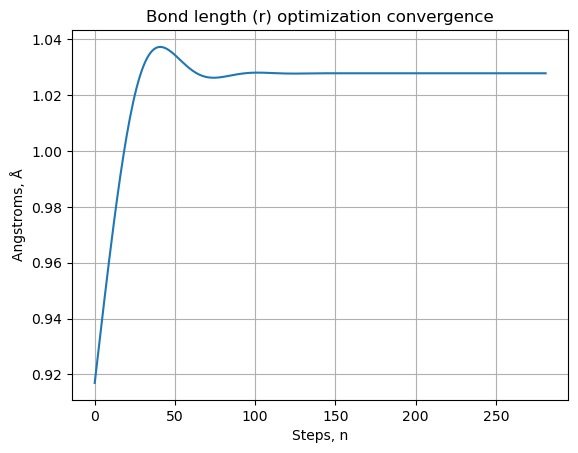

In [142]:
import matplotlib.pyplot as plt
np_bl = np.array(bond_length)
np_ba = np.array(bond_angle)
np_en = np.array(energy)
plt.plot(np_bl)
plt.xlabel("Steps, n")
plt.ylabel("Angstroms, Å")
plt.title("Bond length (r) optimization convergence")
plt.grid(True)

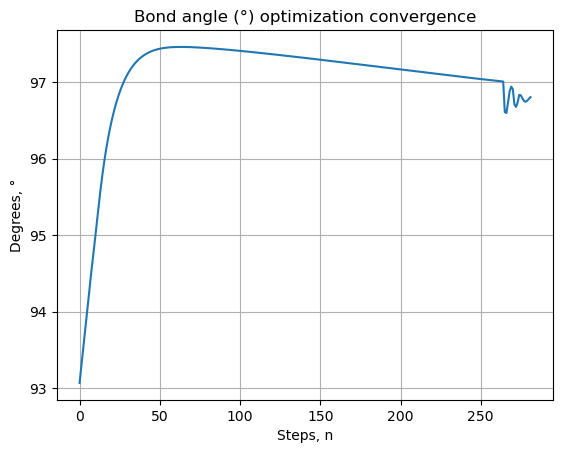

In [143]:
plt.plot(np_ba)
plt.xlabel("Steps, n")
plt.ylabel("Degrees, \u00b0")
plt.title("Bond angle (\u00b0) optimization convergence")
plt.grid(True)

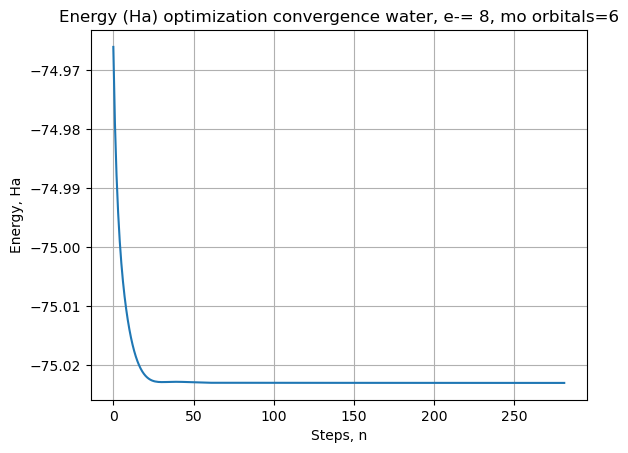

In [144]:
plt.plot(energy)
plt.xlabel("Steps, n")
plt.ylabel("Energy, Ha")
plt.title("Energy (Ha) optimization convergence water, e-= 8, mo orbitals=6")
plt.grid(True)

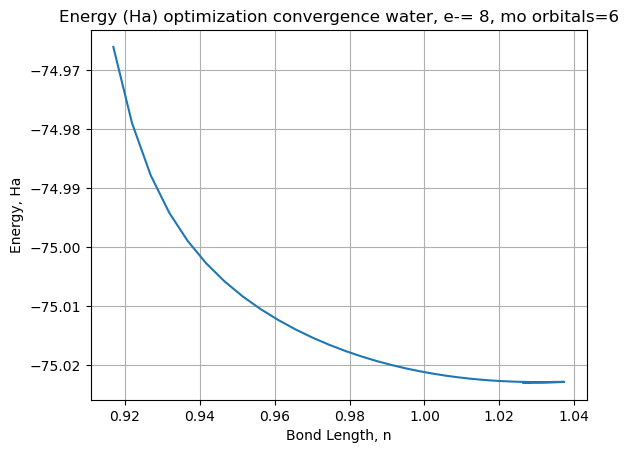

In [145]:
plt.plot(np_bl, np_en)
plt.xlabel("Bond Length, n")
plt.ylabel("Energy, Ha")
plt.title("Energy (Ha) optimization convergence water, e-= 8, mo orbitals=6")
plt.grid(True)

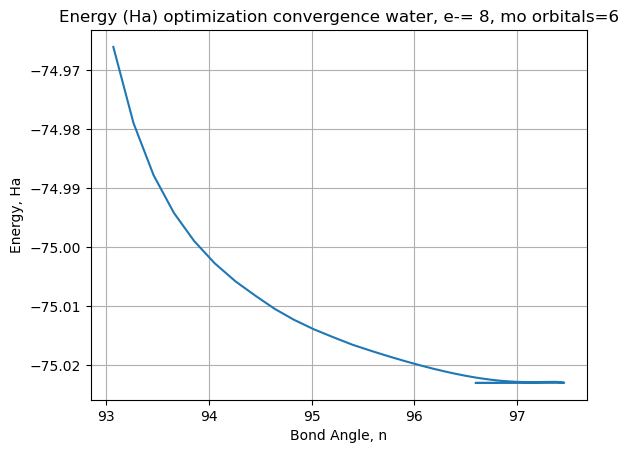

In [146]:
plt.plot(np_ba, np_en)
plt.xlabel("Bond Angle, n")
plt.ylabel("Energy, Ha")
plt.title("Energy (Ha) optimization convergence water, e-= 8, mo orbitals=6")
plt.grid(True)

In [ ]:
x

In [ ]:
# Code for preparing ansatz:

from pyscf import gto, scf, ci
from pennylane.qchem import import_state
from pennylane import numpy as np

num_qubits = 14
def circuit(theta, initial_state):
    # prepares reference state
    qml.StatePrep(initial_state, wires=range(num_qubits))
        
    # apply 2 gates for simplicty:
    qml.SingleExcitation(theta[0], wires=[1, 3])
    qml.DoubleExcitation(theta[1], wires=[0, 1, 4, 5])
                             
    # returns expectation value of the ansatz prepared from this quantum circuit:   
    return qml.expval(hamiltonian)

def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons, 
                                           active_orbitals = active_orbitals)[0]

symbols = ["O", "H", "H"]
active_electrons = 8; active_orbitals = 6
qubits = active_orbitals * 2
theta = np.array([0.0] * 2, requires_grad=True)
x = x
hamiltonian = H(x)

# create the H2O molecule
mol = gto.M(atom=[["O", (0.        ,  0.7581    , -0.5086)],
                  ["H", (-1.49139892,  0.29819887, -1.2393812)],
                  ["H", (-0.68850404,  2.16155953,  0.21671681)]], charge=0)

# Create cisd initial state for the selected active-space
# prepare for active space of 8-electrons, 3-orbitals
mol.nelectron = 8
mol.build()

# perfrom restricted Hartree-Fock and then CISD
myhf = scf.RHF(mol).run()
myci = ci.CISD(myhf).run()
wf_cisd = import_state(myci, tol=1e-1)
print(f"CISD-based state vector: \n{np.round(wf_cisd.real, 4)}")

# Finally, calculate observable
print(circuit(theta, wf_cisd))

In [ ]:
len(wf_cisd)

In [ ]:
np.log2(len(wf_cisd))

In [ ]:
wf_cisd

In [50]:
r_test = np.array([2], requires_grad = True)
angle_test = np.array([96], requires_grad = True)

In [51]:
grad_r(theta, r_test, angle_test)

tensor([-0.02727727], requires_grad=True)

In [97]:
def grad_r_fs(params, r, angle): #evaluate the expectation of the gradient components (each of the nuclear components of the Hamiltonian)
    grad_h = finite_diff_r(H, r,angle)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    
    r_gradient.append(grad)
    
    return np.array(grad)

In [98]:
def grad_r_fd(params, r, angle): #evaluate the expectation of the gradient components (each of the nuclear components of the Hamiltonian)
    grad_h = finite_diff_r_fd(H, r,angle)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    
    r_gradient.append(grad)
    
    return np.array(grad)

In [100]:
r_test = 1.028
angle_test = 96.77
grad_r_fs(theta, r_test, angle_test), grad_r_fd(theta, r_test, angle_test)

(tensor([1.65394412], requires_grad=True),
 tensor([0.00560037], requires_grad=True))

In [102]:
r_test = 1.022
angle_test = 96.77
grad_r_fs(theta, r_test, angle_test), grad_r_fd(theta, r_test, angle_test)

(tensor([-0.02035179], requires_grad=True),
 tensor([-0.01790764], requires_grad=True))

In [103]:
r_test = 1.023
angle_test = 96.77
grad_r_fs(theta, r_test, angle_test), grad_r_fd(theta, r_test, angle_test)

(tensor([-0.01636842], requires_grad=True),
 tensor([-0.01393687], requires_grad=True))

In [104]:
r_test = 1.024
angle_test = 96.77
grad_r_fs(theta, r_test, angle_test), grad_r_fd(theta, r_test, angle_test)

(tensor([-0.01240637], requires_grad=True),
 tensor([-0.00998734], requires_grad=True))

In [105]:
r_test = 1.025
angle_test = 96.77
grad_r_fs(theta, r_test, angle_test), grad_r_fd(theta, r_test, angle_test)

(tensor([1.63710555], requires_grad=True),
 tensor([-0.00605897], requires_grad=True))

In [106]:
r_test = 1.026
angle_test = 96.77
grad_r_fs(theta, r_test, angle_test), grad_r_fd(theta, r_test, angle_test)

(tensor([1.64274259], requires_grad=True),
 tensor([-0.00215162], requires_grad=True))

In [107]:
r_test = 1.027
angle_test = 96.77
grad_r_fs(theta, r_test, angle_test), grad_r_fd(theta, r_test, angle_test)

(tensor([1.64835542], requires_grad=True),
 tensor([0.00173478], requires_grad=True))

In [108]:
r_test = 1.028
angle_test = 96.77
grad_r_fs(theta, r_test, angle_test), grad_r_fd(theta, r_test, angle_test)

(tensor([1.65394412], requires_grad=True),
 tensor([0.00560037], requires_grad=True))